In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from utils import *

%matplotlib inline

In [2]:
assert tf.__version__ == '2.0.0-beta0',"Please User Tensorflow 2.0.0beta0"

In [3]:
sign = tf.saved_model.load(f"checkpoints/saved_model")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
model = sign.signatures['serving_default']

In [5]:
def get_image(path):
    image = cv2.imread(path)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]
    return input_tensor,image

In [6]:
def get_pred(tensor):
    output_dict = model(tensor)
    output_dict.pop("num_detections")
    for i in output_dict.keys():
        output_dict[i] = output_dict[i].numpy()
    return output_dict

In [7]:
colors = {
    "WBC":(255,255,255),
    "RBC":(255,0,0),
    "Platelets":(0,0,255)
}

def get_boxes(out,x,y):
    boxes = []
    clss = []
    for box,cls,mask,score in zip(*[out[i][0] for i in sorted(out.keys())]):
        boxes.append({
            "mask":mask,
            "class":cls,
            "score":score,
            "box":{
                "ymin":int(box[0]*y),
                "xmin":int(box[1]*x),
                "ymax":int(box[2]*y),
                "xmax":int(box[3]*x)
            },
            "box_color":classes[cls]['color'],
        })                     
        clss.append(int(cls))

    clss = [
            {
                "name":classes[i]['name'],
                "color":'#%02x%02x%02x' % classes[i]['color'],
                "render":True
            } 
            for i in set(clss)
        ]
        
            
    return [i for i in boxes if i['score'] > 0.7]

In [8]:
tensor,image = get_image("./images/2.jpg")
y,x,c = image.shape
preds = get_pred(tensor)

In [9]:
boxes = get_boxes(preds,x,y)

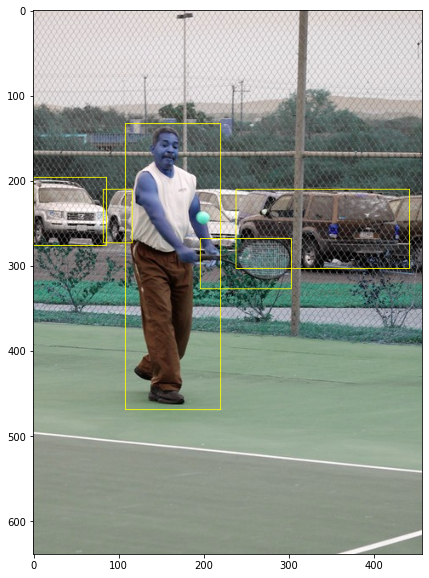

In [10]:
def plot_boxes(img,boxes):
    plt.figure(figsize=(12,10))
    for box in boxes:
        img = cv2.rectangle(img,(box['box']['xmin'],box['box']['ymin']),(box['box']['xmax'],box['box']['ymax']),(255,255,0),1)
    plt.imshow(img)
    
plot_boxes(image,boxes)

In [20]:
box = boxes[0]

In [21]:
h = box['box']['ymax'] - box['box']['ymin']
w = box['box']['xmax'] - box['box']['xmin']

In [74]:
mask = cv2.resize(box['mask'],(w,h),interpolation = cv2.INTER_NEAREST)

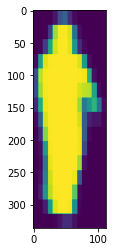

In [75]:
plt.imshow(mask)

In [76]:
color = np.array(box['box_color'])

In [77]:
color = 255 - color

In [78]:
mask_ = (mask.reshape(*mask.shape,1) * color).astype(np.uint8)

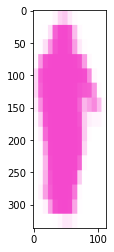

In [79]:
plt.imshow(255-mask_)